In [1]:
import yasp
# yasp.debug = True
import sys
import os
yasp_prefix = yasp.yasp_feature("prefix")
site_packages = os.path.join(sys.prefix, 'lib', f'python{sys.version[:3]}', 'site-packages')
add_path = os.path.join(yasp_prefix, 'lib', f'python{sys.version[:3]}', 'site-packages')
sys.path.append(add_path)

In [2]:
yasp.module_load_cppyy('bundle/hepbase')
yasp.module_load_cppyy('heppyy/current')
yasp.module_load_cppyy('alian/current')

import heppyy
fj = heppyy.load_cppyy('fastjet')
std = heppyy.load_cppyy('std')
alian_cpp = heppyy.load_cppyy('alian')

/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/loader.py:90: UserWarning: No precompiled header available (/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/etc not writable); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
[yasp-i] Running in Jupyter: True


In [3]:
import alian
if yasp.in_jupyter_notebook():
  from tqdm.notebook import tqdm
else:
  from tqdm import tqdm


In [4]:
fj.ClusterSequence().print_banner()

jet_algorithm = fj.antikt_algorithm
jet_R = 0.6
jet_eta_max = 2.0
bg_y_max = 0.9
bg_grid_spacing = 0.1

jet_pt_min = 100
jet_def = fj.JetDefinition(jet_algorithm, jet_R)
area_def = fj.AreaDefinition(fj.active_area, fj.GhostedAreaSpec(jet_eta_max + jet_R, 1, 0.01))
jet_selector = fj.SelectorAbsEtaMax(jet_eta_max) * fj.SelectorPtMin(jet_pt_min)

# need for a background estimator?
bg_estimator = fj.GridMedianBackgroundEstimator(bg_y_max, bg_grid_spacing)

jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = fj.contrib.LundGenerator(jet_def_lund)
print('making lund diagram for all jets...')
print(f' {lund_gen.description()}')


#--------------------------------------------------------------------------
#                         FastJet release 3.4.4-devel
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
making lund diagram for all jets...
 LundGenerator with Recluster with 

In [5]:
pt_hat_min = jet_pt_min / (jet_R * 2.)

pythia_cmnd = os.path.join(alian.alian_settings.src_path, 'config/pythia-pp-hardQCD-5TeV-Monash.cmnd')
pythia_settings = ['PhaseSpace:pThatMin = {}'.format(pt_hat_min)]

from heppyy.pythia_util.configuration import create_and_init_pythia
pythia = create_and_init_pythia(pythia_settings, pythia_cmnd)


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.310      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 25 Jul 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 16 May 2025 at 18:42:21    |  | 
 |  |                                                                              |  | 
 |  |   Program docu

In [6]:
from alian.io.pythia_io import psj_from_particle_with_index
pythia_offset_index = 0
nevents = 10
i = 0
for i in tqdm(range(nevents)):
    if not pythia.next():
        continue
    print(f'Event: {i} nparts: {pythia.event.size()}')
    i += 1
    #psjv = std.vector[fj.PseudoJet]([psj_from_particle_with_index(p, i + pythia_offset_index) 
    #                                for i, p in enumerate(pythia.event) if p.isFinal() and p.isVisible() and p.isCharged()])
    psjv = std.vector[fj.PseudoJet]([psj_from_particle_with_index(p, i + pythia_offset_index) 
                                    for i, p in enumerate(pythia.event) if p.isFinal()])
    ca = fj.ClusterSequenceArea(psjv, jet_def, area_def)
    jets = fj.sorted_by_pt(jet_selector(ca.inclusive_jets()))
    leadpt = -1
    if jets.size() > 0:
        leadpt = jets[0].perp()
    else:
        continue
    print(f'{i} : n particles: {psjv.size()} -> njets: {jets.size()} | highest pt: {leadpt}')
    for j in jets:
        lunds = lund_gen.result(j)
        print(f'jet pT={j.perp()}')
        for i, l in enumerate(lunds):
            print('- L {} pT={:5.2f} eta={:5.2f}'.format(i, l.pair().perp(), l.pair().eta()))
            print('  Deltas={}'.format(l.Delta()))
            print('  kts={}'.format(l.kt()))
            print()


[i-alian.io.pythia_io] Running in Jupyter Notebook, using tqdm.notebook


  0%|          | 0/10 [00:00<?, ?it/s]

Event: 0 nparts: 661
1 : n particles: 221 -> njets: 2 | highest pt: 128.84840450560392
jet pT=128.84840450560392
- L 0 pT=128.85 eta= 1.86
  Deltas=0.5222227146108276
  kts=0.09092769335980244

- L 1 pT=128.67 eta= 1.86
  Deltas=0.32447519843724915
  kts=0.018057602994285327

- L 2 pT=128.62 eta= 1.86
  Deltas=0.16269192683696213
  kts=0.38283525719661027

- L 3 pT=126.30 eta= 1.86
  Deltas=0.1272378804698769
  kts=0.8769082037573056

- L 4 pT=119.46 eta= 1.86
  Deltas=0.12814186248922121
  kts=0.5359519205286927

- L 5 pT=115.28 eta= 1.86
  Deltas=0.08731816429063731
  kts=0.6970817016632019

- L 6 pT=107.30 eta= 1.86
  Deltas=0.03256661557554347
  kts=0.24559931537893231

- L 7 pT=99.76 eta= 1.86
  Deltas=0.02979465016647401
  kts=0.3101231264816592

- L 8 pT=89.35 eta= 1.86
  Deltas=0.013812594396123798
  kts=0.4217479890504579

- L 9 pT=58.82 eta= 1.86
  Deltas=0.004554831435851865
  kts=0.06254764153971307

jet pT=106.2025274797235
- L 0 pT=106.20 eta= 1.84
  Deltas=0.489515323833

WARNING from FastJet: Recluster: the original cluster sequence is lacking explicit ghosts; area support will no longer be available after re-clustering
WARNING from FastJet: Recluster: the original cluster sequence is lacking explicit ghosts; area support will no longer be available after re-clustering
WARNING from FastJet: Recluster: the original cluster sequence is lacking explicit ghosts; area support will no longer be available after re-clustering
WARNING from FastJet: Recluster: the original cluster sequence is lacking explicit ghosts; area support will no longer be available after re-clustering
WARNING from FastJet: Recluster: the original cluster sequence is lacking explicit ghosts; area support will no longer be available after re-clustering (LAST SUCH WARNING)


In [7]:
pythia_offset_index = 0
nevents = 10000
i = 0
all_jets = []
for i in tqdm(range(nevents)):
    if not pythia.next():
        continue
    # print(f'Event: {i} nparts: {pythia.event.size()}')
    i += 1
    psjv = std.vector[fj.PseudoJet]([psj_from_particle_with_index(p, i + pythia_offset_index) 
                                    for i, p in enumerate(pythia.event) if p.isFinal() and p.isVisible() and p.isCharged()])
    ca = fj.ClusterSequenceArea(psjv, jet_def, area_def)
    jets = fj.sorted_by_pt(jet_selector(ca.inclusive_jets()))
    leadpt = -1
    if jets.size() > 0:
        leadpt = jets[0].perp()
    else:
        continue
    # print(f'{i} : n particles: {psjv.size()} -> njets: {jets.size()} | highest pt: {leadpt}')
    for j in jets:
        lunds = lund_gen.result(j)
        # print(f'jet pT={j.perp()}')
        j_dict = {'pt': j.perp(), 'eta': j.eta(), 'phi': j.phi(), 'area': j.area(), 'lunds': []}
        for i, l in enumerate(lunds):
            pt1 = l.harder().perp()
            pt2 = l.softer().perp()
            lund_dict = {'pt': l.pair().perp(), 'pt1': pt1, 'pt2': pt2, 'eta': l.pair().eta(), 'kt': l.kt(), 'delta': l.Delta()}
            j_dict['lunds'].append(lund_dict)
        all_jets.append(j_dict)
        
print(f'found {len(all_jets)} jets')
# print(all_jets)

  0%|          | 0/10000 [00:00<?, ?it/s]

 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame
 PYTHIA Error in StringFragmentation::fragment: stuck in joining
 PYTHIA Error in Pythia::next: hadronLevel failed; try again
 PYTHIA Error in SimpleSpaceShower::pT2nearThreshold: stuck in loop
found 1463 jets


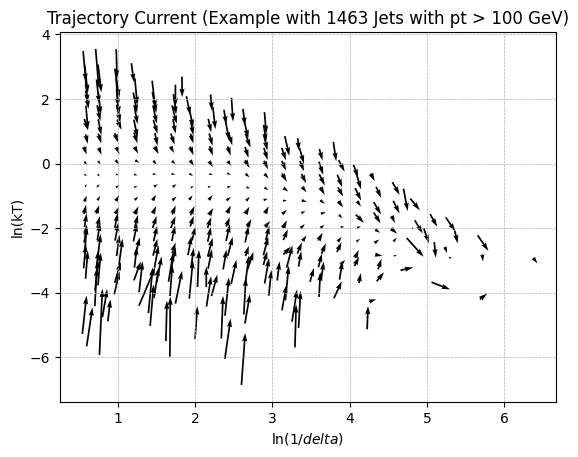

In [8]:
import pandas as pd
import numpy as np

records = []
for jet in all_jets:
    lunds = jet['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i]['kt'], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1]['kt'], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = df.groupby(['ix', 'iy']).agg(
    x=('x', 'mean'),
    y=('y', 'mean'),
    dx=('dx', 'mean'),
    dy=('dy', 'mean')
).dropna().reset_index()

import matplotlib.pyplot as plt
# Plot the trajectory current
plt.figure()
plt.quiver(group['x'], group['y'], group['dx'], group['dy'])
plt.xlabel(r'ln(1/$delta$)')
plt.ylabel('ln(kT)')
plt.title(f'Trajectory Current (Example with {len(all_jets)} Jets with pt > {jet_pt_min} GeV)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

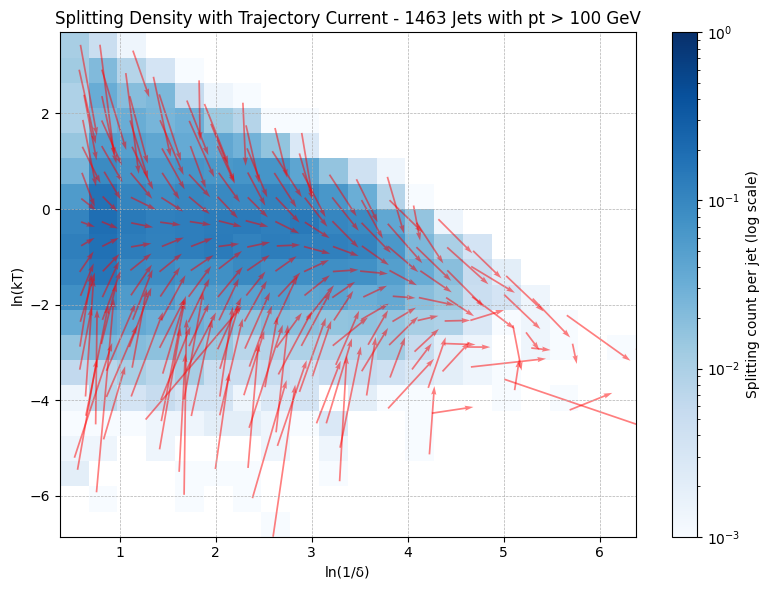

In [9]:
import matplotlib.colors as mcolors

# Grid resolution
nx, ny = 20, 20
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)

# Assign each point to a bin
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

# Plot
plt.figure(figsize=(8, 6))

# 1) density background
# Normalize by number of jets
weights = np.ones_like(df['x']) / len(all_jets)

plt.hist2d(
    df['x'], df['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current
plt.quiver(group['x'], group['y'], group['dx'], group['dy'], 
           angles='xy', scale_units='xy', scale=2.0, width=0.003, color='red', alpha=0.5)

plt.xlabel('ln(1/δ)')
plt.ylabel('ln(kT)')
plt.title(f'Splitting Density with Trajectory Current - {len(all_jets)} Jets with pt > {jet_pt_min} GeV')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

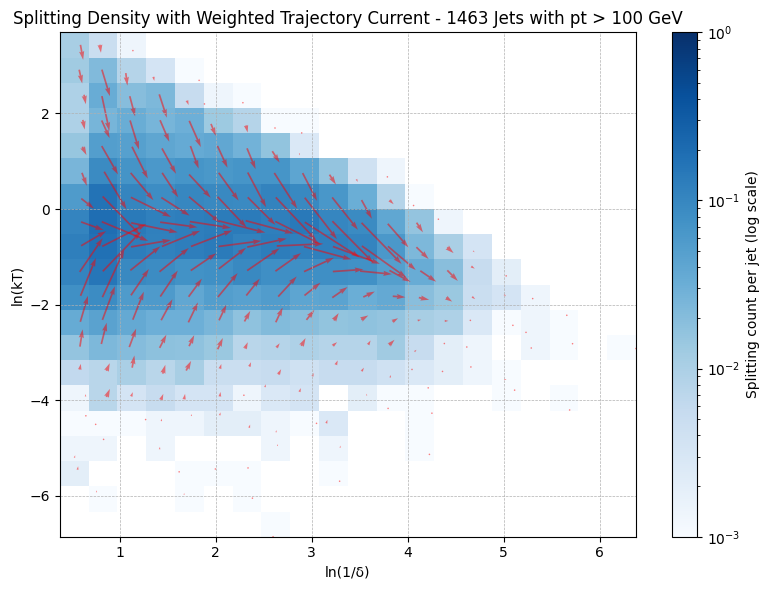

In [10]:
# Compute the density (weight) for each bin
hist, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=[x_bins, y_bins], weights=weights)

# Map group['ix'], group['iy'] to the corresponding density
arrow_weights = hist[group['ix'], group['iy']]

# Optionally, normalize or rescale arrow_weights for better visualization
arrow_weights = arrow_weights / arrow_weights.max()  # scale to [0, 1]

# Scale dx and dy by the weights
dx_scaled = group['dx'] * arrow_weights
dy_scaled = group['dy'] * arrow_weights

plt.figure(figsize=(8, 6))
plt.hist2d(
    df['x'], df['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# Quiver with scaled arrows
plt.quiver(group['x'], group['y'], dx_scaled, dy_scaled, 
           angles='xy', scale_units='xy', scale=0.7, width=0.003, color='red', alpha=0.5)

plt.xlabel('ln(1/δ)')
plt.ylabel('ln(kT)')
plt.title(f'Splitting Density with Weighted Trajectory Current - {len(all_jets)} Jets with pt > {jet_pt_min} GeV')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

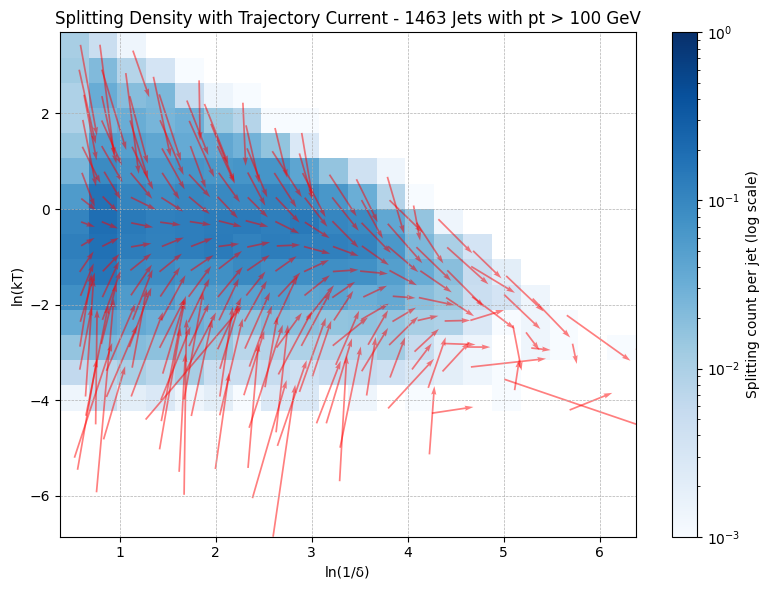

In [11]:
import matplotlib.colors as mcolors

# Grid resolution
nx, ny = 20, 20
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)

# Assign each point to a bin
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin (group is calculated on full df)
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

# Apply cut for plotting only (ln(kT) > -4)
df_plot = df[df['y'] > -4]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(all_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver from full group, not cut)
plt.quiver(group['x'], group['y'], group['dx'], group['dy'], 
           angles='xy', scale_units='xy', scale=2.0, width=0.003, color='red', alpha=0.5)

plt.xlabel('ln(1/δ)')
plt.ylabel('ln(kT)')
plt.title(f'Splitting Density with Trajectory Current - {len(all_jets)} Jets with pt > {jet_pt_min} GeV')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

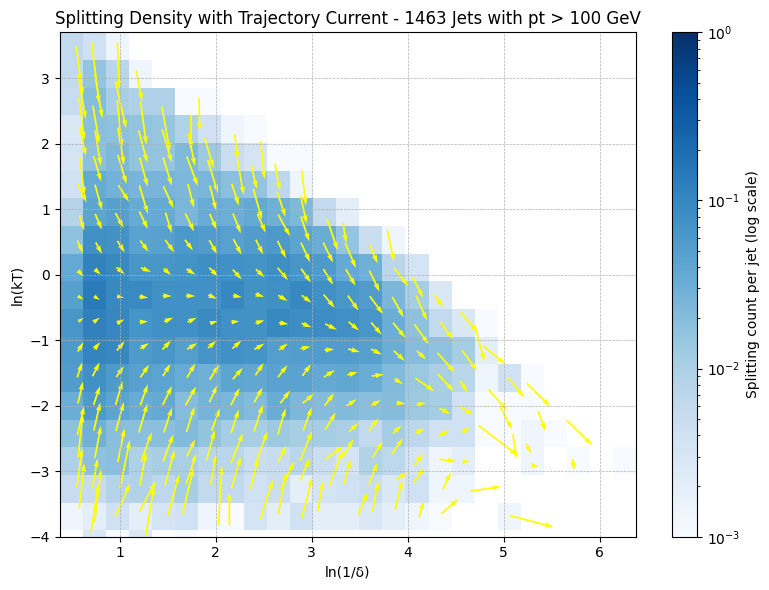

In [12]:
import matplotlib.colors as mcolors

# Grid resolution
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)

# Assign each point to a bin
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin (group is calculated on full df)
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

# Apply cut for plotting only (ln(kT) > -4)
df_plot = df[df['y'] > -4]

# Drop arrows starting at ln(kT) < -4
group_plot = group[group['y'] > -4]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(all_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='yellow', alpha=1.0)

plt.xlabel('ln(1/δ)')
plt.ylabel('ln(kT)')
# plt.ylim(-4, 4)  # <-- Adjust y-axis: show only ln(kT) > -4
plt.ylim(-4, None)  # <-- Adjust y-axis: show only ln(kT) > -4
plt.title(f'Splitting Density with Trajectory Current - {len(all_jets)} Jets with pt > {jet_pt_min} GeV')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

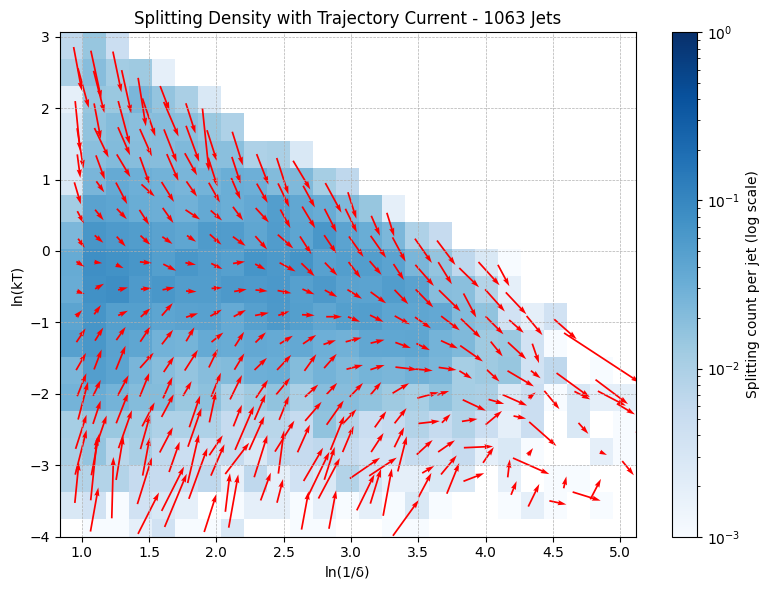

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
fname = 'pythia_lund_jet.parquet'
if not os.path.exists(fname):
    raise FileNotFoundError(f"File {fname} not found. Please check the path.")
df_jets = pd.read_parquet(fname)

# Extract lund records from all jets
records = []
for _, row in df_jets.iterrows():
    lunds = row['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i]['kt'], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1]['kt'], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

# Apply cut for plotting only (ln(kT) > -4)
df_plot = df[df['y'] > -4]
group_plot = group[group['y'] > -4]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(df_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='red', alpha=1.0)

plt.xlabel('ln(1/δ)')
plt.ylabel('ln(kT)')
plt.ylim(-4, None)
plt.title(f'Splitting Density with Trajectory Current - {len(df_jets)} Jets')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()